# Large-scale Distributed $k$-means Algorithm

In this Notebook, we'll focus on the development of a simple distributed algorithm. As for the Notebook on SGD, we focus on iterative algorithms, which eventually converge to a desired solution.

In what follows, we'll proceed with the following steps:

* We first introduce formally the $k$-means algorithm
* Then we focus on a serial implementation. To do this, we'll first generate some data using scikit. In passing, we'll also use the $k$-means implementation in scikit to have a baseline to compare against.
* Subsequently, we will focus on some important considerations and improvements to the serial implementation of $k$-means.
* At this point, we'll design our distributed version of the $k$-means algorithm using pyspark, and re-implement the enhancements we designed for the serial version 

#### References:
* https://en.wikipedia.org/wiki/K-means_clustering
* http://nbviewer.jupyter.org/github/ethen8181/machine-learning/blob/master/clustering/kmeans.ipynb
* https://apache.googlesource.com/spark/+/master/examples/src/main/python/kmeans.py
* https://github.com/castanan/w2v/blob/master/ml-scripts/w2vAndKmeans.py


#### Preamble code

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.datasets.samples_generator import make_blobs
import time

# Preliminaries: the $k$-means algorithm

$k$-means clustering aims to partition $n$ $d-$dimensional observations into $k$ clusters in which each observation belongs to the cluster with the nearest mean, serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells.
The problem is computationally difficult (NP-hard); however, there are efficient heuristic algorithms that are commonly employed and converge quickly to a local optimum. In this Notebook we'll focus on one of them in particular: the Lloyd algorithm.

The $k$-means problem can be formalized as follows. Given a set of observations $(x_1, x_2, \cdots, x_n)$, where each observation is a $d$-dimensional real vector, $k$-means clustering aims to partition the $n$ observations into $k \leq n$ sets $S = \{S_1, S_2, \cdots, S_k\}$ so as to minimize the within-cluster sum of squares (WCSS) (i.e. variance). 
The objective is to find:

$$
\arg \min_S \sum_{i=1}^{k} \sum_{x \in S_i} || \boldsymbol{x} - \boldsymbol{\mu_i} ||^2
$$

The most common algorithm uses an iterative refinement technique. Given an initial set of $k$ centroids $\mu_1^{(1)}, \cdots, \mu_k^{(1)}$ , the algorithm proceeds by alternating between two steps: in the **assignment step**, observations are associated to the closest **centroid**, in terms of squared Euclidean distance; in the **update step** new centroids are computed based on the new points associated to each centroid. Note: $\mu_i^{(t)}$ stands for the $i$-th centroid as of the $t$-th iteration. So $\mu_1^{(1)}$ is the centroid 1 at iteration 1.

## Algorithm pseudo-code
It is important to work on a principled approach to the design of large-scale algorithms, and this starts with using good data structures and scientific libraries, such as ```numpy``` and ```scipy```. In particular, we will focus on the use of ```numpy``` arrays, which come with efficient methods for array operations. A pseudo-code for the $k$-means algorithm is specified below:

```python
def kmeans(X, k, maxiter, seed=None):
    """
    specify the number of clusters k and
    the maximum iteration to run the algorithm
    """

    # randomly choose k data points as initial centroids
    centroids = X[rand_indices]
    
    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        # compute the distance matrix between each data point and the set of centroids
        distance_matrix = # row Index = data point Index; col Index = centroid Index; value=distance
        # assign each data point to the closest centroid
        cluster_assignment = # array Index = data point Index; array value = closest centroid Index
        
        # UPDATE STEP
        # select all data points that belong to cluster i and compute
        # the mean of these data points (each feature individually)
        # this will be our new cluster centroids
        new_centroids = ...
        
        # STOP CONDITION
        # if centroids == new_centroids => stop
 
    
```

# Synthetic data generation: working in bi-dimensional spaces

Next, we use sklearn to generate some synthetic data to test our algorithm.

In [2]:
X, y = make_blobs(n_samples = 300, centers = 4,
                  random_state = 0, cluster_std = 0.6)

In [3]:
# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

# scatter plot
plt.scatter(X[:, 0], X[:, 1], s = 50)
plt.ylim(-2, 10)
plt.xlim(-6, 6)
plt.gca().set_aspect('equal')
plt.show()

<div class="alert alert-block alert-info">
<strong>Question 1.</strong> Implement your own version of k-means, as a serial algorithm.

Follow the guidelines below:

<ul>
    <li> Define a function to perform k-means clustering. The function should accept as inputs: the training data x, the number of clusters k, and the iteration budget you allocate to the algorithm. Additional arguments might include the use of a random seed to initialize centroids.</li>
    <li>The function should output the centroids, and the cluster assignment, that is, to which centroid each data point is assigned to</li>
    <li> Optionally, keep track of the position of the centroids, for each iteration.</li>
</ul>

<br>
Once the ```kmeans``` function is defined, you can generate input data according to the cell above, that uses scikitlearn.
<br>

The output of your cell should contain the following information:
<ul>
    <li> Print the number of data points that belong to each cluster</li>
    <li> Plot the clustered data points:</li>
    <ul>
        <li>Using different colors for each cluster</li>
        <li>Plot the centroid positions for each cluster</li>
    </ul>
</ul>
</div>

In [7]:
import random as rd
import math as m

def distance_eucli(U,V):
    return m.sqrt(np.dot(U, U) - 2 * np.dot(U, V) + np.dot(V, V))
    # this function returns the euclidien distance between two numpy arrays U and V

def kmeans(X, k, maxiter, seed=None):
    # ---------------
    # INITIALISATION STEP
    # ---------------
    # choose randomly k initial centroids among the datapoints
    
    centroids = []
    for ik in range(k):
        index_random_centroid_k = rd.randint(0, X.shape[0] - 1)
        # we randomly choose the index of a point among our datapoints
        centroids.append([X[index_random_centroid_k, 0], X[index_random_centroid_k, 1]])
        # we append to the list of centroids the coordinates of the point corresponding to this index
    # with the loop, we populate the centroids list with k initial centroids.
    centroids = np.asarray(centroids)
    # we convert the list into an numpy array to be able to use our distance_eucli() function on it later
    
    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        
        distance_matrix = [[distance_eucli(data_point, centroid) for centroid in centroids] for data_point in X]
        # we compute the distance matrix between each data point and the set of centroids with this scheme :
        # row Index = data point Index; col Index = centroid Index; value=distance
        
        cluster_assignment = [ list_dist.index( min(list_dist) ) for list_dist in distance_matrix]
        # we assign each data point to the closest centroid in the cluster_assignment vector with this scheme :
        # array Index = data point Index; array value = closest centroid Index
        
        # ---------------
        # UPDATE STEP
        # ---------------
     
        cluster_matrix = [[] for ik in range(k)]
        for index in range(len(cluster_assignment)) :
            cluster_matrix[cluster_assignment[index]].append([X[index, 0], X[index, 1]])
        # we gather the data points from the same cluster in the same list :
        # the i th row of the cluster_matrix contains all data points which are closer to the i th centroid
            
        new_centroids = [tuple(np.mean(list_point, axis=0)) for list_point in cluster_matrix]
        # the i th element of the new_centroids list is the mean of the i th row of the cluster_matrix
        
        # ---------------
        # STOP CONDITION
        # ---------------
        list_centroids = [tuple(x) for x in centroids]
        # to compare the centroids between two itarations of the algorithm, we need list of tuple
        if ((set(list_centroids) - set(new_centroids)) == []):
        # if all elements that are only in one of the two liste are in fact an empty list
        # which means : if all the elements of list_centroids are also in new_centroids and vice versa
            break
            # we stop before we reach the maximum number of iteration
        else:
            centroids=new_centroids
            #we iterate again with the updated centroids list
            
    return new_centroids, cluster_assignment

final_centroids, y_pred = kmeans(X , 4, 500)

x_final_centroids = [ final_centroids[i][0] for i in range(4)]
y_final_centroids = [ final_centroids[i][1] for i in range(4)]

plt.scatter(X[:, 0], X[:, 1], c =y_pred , s = 50)
plt.scatter(x_final_centroids, y_final_centroids, color='r', marker='+')
plt.ylim(-2, 10)
plt.xlim(-6, 6)
plt.gca().set_aspect('equal')
plt.show()


**Comments**
Depending on the random choice of the initial centroids vectors, the algorithm converges more or less faster. The number of iterations to reach the optimal clustering is variable and hard to determine *a priori*.

***

<div class="alert alert-block alert-info">
<strong>Question 2.</strong> Use the built-in k-means implementation in sklearn and determine centroids and clusters.

Follow the guidelines below:

<ul>
    <li> Use the KMeans algorithm from sklearn</li>
    <li> Use the fit_predict method to cluster data</li>
    <li> Use the cluster_centers_ method to retrieve centroids</li>
</ul>

The output of your cell should contain the following information:
<ul>
    <li> Plot the clustered data points, using the same code your have produced for Question.1</li>
    <ul>
        <li>Using different colors for each cluster</li>
        <li>Plot the centroid positions for each cluster</li>
    </ul>
</ul>
</div>

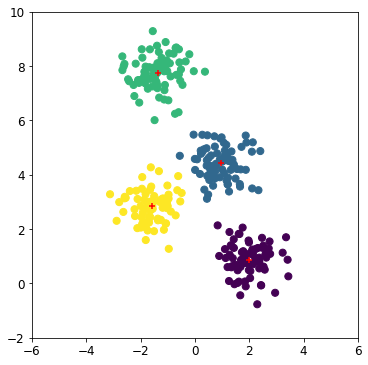

In [6]:
kmeans = KMeans(n_clusters=4, random_state=0)
y_pred = kmeans.fit_predict(X)
final_centroids = kmeans.cluster_centers_

plt.scatter(X[:, 0], X[:, 1], c =y_pred , s = 50)
plt.scatter(final_centroids[:, 0], final_centroids[:, 1], color='r', marker='+')
plt.ylim(-2, 10)
plt.xlim(-6, 6)
plt.gca().set_aspect('equal')
plt.show()

***

<div class="alert alert-block alert-info">
<strong>Question 3.</strong> Use the sklearn dataset API to generate alternative synthetic data to test your k-means algorithm implementation.

Follow the guidelines from this document: http://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html#sphx-glr-auto-examples-cluster-plot-cluster-comparison-py


The output of your cell should contain the following information:
<ul>
    <li> Plot the new synthetic dataset you generated
    <li> Plot the clustered data points, using the same code your have produced for Question.1</li>
    <ul>
        <li>Using different colors for each cluster</li>
        <li>Plot the centroid positions for each cluster</li>
    </ul>
</ul>
</div>

a plot the new synthetic dataset we generated


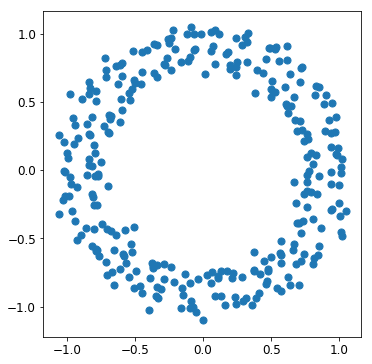

In [10]:
from sklearn.datasets.samples_generator import make_circles

Xc, yc = make_circles(n_samples = 300, noise=0.05)

# change default figure and font size
plt.rcParams['figure.figsize'] = 8, 6 
plt.rcParams['font.size'] = 12

print("a plot the new synthetic dataset we generated")

# scatter plot
plt.scatter(Xc[:, 0], Xc[:, 1], s = 50)
plt.gca().set_aspect('equal')
plt.show()

a plot of the clustered data points, using the same code we have produced for Question.1


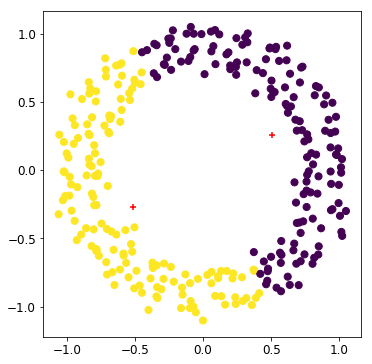

In [12]:
final_centroids, y_pred = kmeans(Xc , 2, 500)

x_final_centroids = [ final_centroids[i][0] for i in range(2)]
y_final_centroids = [ final_centroids[i][1] for i in range(2)]

print("a plot of the clustered data points, using the same code we have produced for Question.1")

plt.scatter(Xc[:, 0], Xc[:, 1], c =y_pred , s = 50)
plt.scatter(x_final_centroids, y_final_centroids, color='r', marker='+')
plt.gca().set_aspect('equal')
plt.show()

# A simplified analysis of algorithm convergence

One well-known weakness of $k$-means is that the algorithm's performance is closely tied with the randomly generated initial centroids' quality. If the algorithm starts with a set of bad inital centers, it will get stuck in a local minimum.

Instead of taking a formal approach to study the convergence of $k$-means, let's study it with an experimental approach. One thing we can do is to build a measure of clustering quality: intuitively, a good clustering result should produce clusters in which data points should be very close to their centroids, and very far from other centroids. In this Notebook, we'll look at a metric called the **total within Sum of Squares**, which is sometimes referred ot as heterogeneity. Mathematically, we define heterogeneity as:

$$
\mathcal{H} = \sum_{j=1}^{k} \sum_{i: z_i=j} || \boldsymbol{x_i} - \boldsymbol{\mu_j}||_{2}^{2}
$$

Where $k$ denotes the total number of clusters, $x_i$ is the $i$-th data point, $\mu_j$ is the $j$-th centroid, and $|| \cdot ||_{2}^{2}$ denotes the squared L2 norm (Euclidean distance) between the two vectors.

<div class="alert alert-block alert-info">
<strong>Question 4.</strong> Modify your own version of k-means, to compute heterogeneity as defined above.

Follow the guidelines below:

<ul>
    <li>Use the same method template you used in Question 1</li>
    <li>Add the code required to compute heterogeneity</li>
    <li>The function should return, in addition to the same return values as for the baseline version, the computed heterogeneity
</ul>
</div>

In [14]:
def kmeans_bis(X, k, maxiter, seed) :
    # ---------------
    # INITIALISATION STEP
    # ---------------
    # choose randomly k initial centroids among the datapoints, taking the random seed in account
    
    centroids = []
    rd.seed(seed) 
    for ik in range(k):
        index_random_centroid_k = rd.randint(0, X.shape[0] - 1)
        # we randomly choose the index of a point among our datapoints
        centroids.append([X[index_random_centroid_k, 0], X[index_random_centroid_k, 1]])
        # we append to the list of centroids the coordinates of the point corresponding to this index
    # with the loop, we populate the centroids list with k initial centroids.
    centroids = np.asarray(centroids)
    # we convert the list into an numpy array to be able to use our distance_eucli() function on it later
    
    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        
        distance_matrix = [[distance_eucli(data_point, centroid) for centroid in centroids] for data_point in X]
        # we compute the distance matrix between each data point and the set of centroids with this scheme :
        # row Index = data point Index; col Index = centroid Index; value=distance
        
        cluster_assignment = [ list_dist.index( min(list_dist) ) for list_dist in distance_matrix]
        # we assign each data point to the closest centroid in the cluster_assignment vector with this scheme :
        # array Index = data point Index; array value = closest centroid Index
        
        # ---------------
        # UPDATE STEP
        # ---------------
     
        cluster_matrix = [[] for ik in range(k)]
        for index in range(len(cluster_assignment)) :
            cluster_matrix[cluster_assignment[index]].append([X[index, 0], X[index, 1]])
        # we gather the data points from the same cluster in the same list :
        # the i th row of the cluster_matrix contains all data points which are closer to the i th centroid
            
        new_centroids = [tuple(np.mean(list_point, axis=0)) for list_point in cluster_matrix]
        # the i th element of the new_centroids list is the mean of the i th row of the cluster_matrix
        
        # ---------------
        # STOP CONDITION
        # ---------------
        list_centroids = [tuple(x) for x in centroids]
        # to compare the centroids between two itarations of the algorithm, we need list of tuple
        if ((set(list_centroids) - set(new_centroids)) == []):
        # if all elements that are only in one of the two liste are in fact an empty list
        # which means : if all the elements of list_centroids are also in new_centroids and vice versa
            break
            # we stop before we reach the maximum number of iteration
        else:
            centroids=new_centroids
            #we iterate again with the updated centroids list

    het=0
    for i in range(len(new_centroids)) :
        for j in range(len(cluster_matrix[i])) :
            het+=np.sum(distance_eucli(new_centroids[i],cluster_matrix[i][j]))
    # we compute the heterogenity as per its formula

    return new_centroids, cluster_assignment, het

final_centroids, y_pred, heterogeneity = kmeans_bis(X , 4, 500, None )

print('heterogeneity :',heterogeneity)

heterogeneity : 341.27620521


***

<div class="alert alert-block alert-info">
<strong>Question 5.</strong> Using the modified k-means method you designed, study algorithm convergence as a function of heterogeneity.

Follow the guidelines below:

<ul>
    <li>Run the modified k-means for at least 5 different initial seed values</li>
    <li>Prepare a dictionary data structure containing: key = random seed, value = heterogeneity</li>
    <li>Print seed, heterogeneity values</li>
</ul>

Add your personal comment about the convergence properties of the $k$-means algorithm.

</div>

In [17]:
my_dictionnary = {}
# we create an empty dictionary

for seed in [None, 1, 25090, 50000, 90003, 15000, 2000000] :
# for each seed value    
    final_centroids, y_pred, heterogeneity = kmeans_bis(X , 4, 100, seed)
    # we use our kmeans_bis algorythme and get the heterogeneity
    my_dictionnary[seed] = heterogeneity
    # we add to our dictionary the key-value pair composed by the seed and the heterogeneity 
    
print(my_dictionnary)

{None: 222.893863060689, 1: 341.24910790969437, 25090: 341.24910790969432, 50000: 222.893863060689, 90003: 222.893863060689, 15000: 222.893863060689, 2000000: 222.89386306068883}


**Interpretation**

The heterogeneity computed shows that when the initial centroids are chosen randomly, the algorithm quality is affected. 

After several tries, the expected heterogeneity value for this set of points is 222. 
We see that choosing randomly the initial centroids can lead to a higher heterogeneity and a so, a less performant clustering. 

***

# A technique for a smart centroid initialization: $k$-means++

One effective way to produce good initial centroids to feed to $k$-means is to proceed as follows: instead of randomly generating initial centroids, we will try to spread them out in our $d$-dimensional space, such that they are not "too close" to eachother. If you are interested in the details of this technique, you should refer to the link to the original research paper below: in summary, the $k$-means++ technique allows to improve the quality of the local optima in which $k$-means settles, and to reduce the average runtime of the algorithm.

k-means++: the advantages of careful seeding, by David Arthur and Sergei Vassilvitskii (Stanford University) https://dl.acm.org/citation.cfm?id=1283494

A simplified workflow of the $k$-means++ approach is as follows:


* Choose a data point at random from the dataset, this serves as the first centroid
* Compute the squared euclidean distance of all other data points to the randomly chosen first centroid
* To generate the next centroid, each data point is chosen with the probability (weight) of its squared distance to the chosen center in the current round, divided by the the total squared distance (this is just a normalization to make sure the probability adds up to 1). In other words, a new centroid should be as far as possible from the other centroids
* Next, recompute the probability (weight) of each data point as the minimum of the distance between it and all the centers that are already generated (e.g. for the second iteration, compare the data point's distance between the first and second center and choose the smaller one)
* Repeat step 3 and 4 until we have $k$ initial centroids to feed to the $k$-means algorithm


<div class="alert alert-block alert-info">
<strong>Question 6.</strong> Modify your own version of k-means, to introduce the smart initialization technique described above. Don't forget to keep track of heterogeneity as well! The whole point is to measure if k-means++ really improves on this metric.

<br>
<br>

Follow the guidelines below:

<ul>
    <li>Use the same method template you used in Question 1</li>
    <li>Add the code required to compute the initial clusters according to k-means++</li>
    <li>Add the code required to compute heterogeneity</li>
    <li>The function should return, in addition to the same return values as for the baseline version, the computed heterogeneity
</ul>
</div>

In [8]:
def kmeans_plus(X, k, maxiter, seed) :
    # ---------------
    # INITIALISATION STEP
    # ---------------
    rd.seed(seed)
    
    centroids = []
    index_random_centroid = rd.randint(0, X.shape[0] - 1)
    centroids.append([X[index_random_centroid, 0], X[index_random_centroid, 1]])
    #now we choose randomly only the first centroid, so a this step : len(centroids)=1
    
    # we compute the weights of each data points recursively to choose the best initial batch of centroids
    for i in range(k-1) :
        distance_matrice = [[distance_eucli(data_point, centroid) for centroid in centroids] for data_point in X]
        distance_centroid= [ np.min(distance_matrice[j]) for j in range(len(X)) ]
        index_max = distance_centroid.index(np.max(distance_centroid))
        centroids.append([X[index_max, 0], X[index_max, 1]])
        
        cste_norm=1/(np.sum(distance_matrice[:][i]))
        probability_matrix = np.dot(cste_norm,distance_centroid)
        
    centroids = np.asarray(centroids)
    # we convert the list into an numpy array to be able to use our distance_eucli() function on it later
    
    for itr in range(maxiter):
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        
        distance_matrix = [[distance_eucli(data_point, centroid) for centroid in centroids] for data_point in X]
        # we compute the distance matrix between each data point and the set of centroids with this scheme :
        # row Index = data point Index; col Index = centroid Index; value=distance
        
        cluster_assignment = [ list_dist.index( min(list_dist) ) for list_dist in distance_matrix]
        # we assign each data point to the closest centroid in the cluster_assignment vector with this scheme :
        # array Index = data point Index; array value = closest centroid Index
        
        # ---------------
        # UPDATE STEP
        # ---------------
     
        cluster_matrix = [[] for ik in range(k)]
        for index in range(len(cluster_assignment)) :
            cluster_matrix[cluster_assignment[index]].append([X[index, 0], X[index, 1]])
        # we gather the data points from the same cluster in the same list :
        # the i th row of the cluster_matrix contains all data points which are closer to the i th centroid
            
        new_centroids = [tuple(np.mean(list_point, axis=0)) for list_point in cluster_matrix]
        # the i th element of the new_centroids list is the mean of the i th row of the cluster_matrix
        
        # ---------------
        # STOP CONDITION
        # ---------------
        list_centroids = [tuple(x) for x in centroids]
        # to compare the centroids between two itarations of the algorithm, we need list of tuple
        if ((set(list_centroids) - set(new_centroids)) == []):
        # if all elements that are only in one of the two liste are in fact an empty list
        # which means : if all the elements of list_centroids are also in new_centroids and vice versa
            break
            # we stop before we reach the maximum number of iteration
        else:
            centroids=new_centroids
            #we iterate again with the updated centroids list

    het=0
    for i in range(len(new_centroids)) :
        for j in range(len(cluster_matrix[i])) :
            het+=np.sum(distance_eucli(new_centroids[i],cluster_matrix[i][j]))
    # we compute the heterogenity as per its formula

    return new_centroids, cluster_assignment, het


final_centroids, y_pred, heterogeneity = kmeans_plus(X , 4, 500, None)

x_final_centroids = [ final_centroids[i][0] for i in range(4)]
y_final_centroids = [ final_centroids[i][1] for i in range(4)]

plt.scatter(X[:, 0], X[:, 1], c =y_pred , s = 50)
plt.scatter(x_final_centroids, y_final_centroids, color='r', marker='+')
plt.ylim(-2, 10)
plt.xlim(-6, 6)
plt.gca().set_aspect('equal')
plt.show()

***

<div class="alert alert-block alert-info">
<strong>Question 7.</strong> Similarly to question 5, using the modified k-means method you designed, study algorithm convergence as a function of heterogeneity.
<br>
<br>


Follow the guidelines below:

<ul>
    <li>Run the modified k-means for at least 5 different initial seed values</li>
    <li>Prepare a dictionary data structure containing: key = random seed, value = heterogeneity</li>
    <li>Print seed, heterogeneity values</li>
</ul>

<br>

One additional question to answer is the following: print the average heterogeneity for the baseline k-means algorithm, and the average heterogeneity when using the k-means++ initialization. Compare and comment with your own words.
</div>

In [9]:
het_dict = { }
for seed in [None, 60300, 25090, 5000,9003, 15000, 2000000] :
    final_centroids, y_pred, heterogeneity = kmeans_plus(X , 4, 500, seed)
    het_dict[seed] = heterogeneity
print(het_dict)

{None: 222.893863060689, 60300: 222.893863060689, 25090: 222.893863060689, 5000: 222.89386306068872, 9003: 222.893863060689, 15000: 222.893863060689, 2000000: 222.893863060689}


In [90]:
het=[]
het_plus = []

for seed in [None, 60300, 25090, 5000,9003, 15000, 2000000]:
    final_centroids, y_pred, heterogeneity = kmeans_bis(X , 4, 500, seed)
    final_centroids, y_pred, heterogeneity_plus = kmeans_plus(X , 4, 500, seed)
    het.append(heterogeneity)
    het_plus.append(heterogeneity_plus)
    mean_het=np.mean(het)
    mean_het_plus=np.mean(het_plus)

print('Mean heterogeneity for k-means algorithm : ', mean_het)
print('Mean heterogeneity for k-means++ algorithm : ', mean_het_plus)

Mean heterogeneity for k-means algorithm :  239.801755182
Mean heterogeneity for k-means++ algorithm :  222.893863061


**Interpretation**

The comparison of the two mean values of heterogeneity clearly illustrates the better performance in terms of clustering quality of the second version of the k-means algorithm.

# Determining the value of k: a simple and visual approach, called the Elbow method

Another problem of $k$-means is that we have to specify the number of clusters $k$ before running the algorithm, which we often don't know a priori. 
There are many different heuristics for choosing a suitable value for $k$, the simplest one being the **Elbow method**. Essentially, the idea is to run the $k$-means algorithm using different values of $k$ and plot the corresponding heterogeneity. This measure will decrease as the number of clusters increases, because each cluster will be smaller and tighter. 
By visual inspection of the plot heterogeneity vs. $k$, we will (hopefully!) see that the curve flattens out at some value of $k$: this is what we call an "elbow", and we'll select the value of $k$ corresponding to the "elbow" position.


<div class="alert alert-block alert-info">
<strong>Question 8.</strong> Using the k-means algorithm you implemented, including the smart initialization technique, collect into an array the value of heterogeneity as a function of the number of clusters k, where k is to be selected in the range [2,10].
<br>
<br>


Your output cell should contain:

<ul>
    <li>The plot of heterogeneity vs. k</li>
    <li>A discussion on your visual inspection of the curve, together with a justification for an appropriate choice of the value k</li>
</ul>
</div>

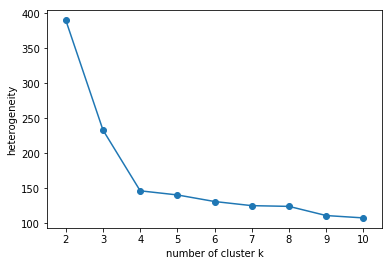

In [7]:
het = []
k_values = [ k for k in range(2,11) ]
for k in k_values :
    final_centroids, y_pred, heterogeneity = kmeans_plus(X , k, 100, None)
    het.append(heterogeneity)
    
plt.plot(k_values, het, marker='o')
plt.xlim(1.5, 10.5)
plt.xlabel("number of cluster k")
plt.ylabel("heterogeneity")
plt.show()


***

**Interpretation**
The Elbow method shows the curve flattening for a value of k=4, that's the expected number of clusters.

# Distributed $k$-means with PySpark

We're now ready to work on a distributed implmentation of the $k$-means algorithm, using the PySpark API.

By now, you should be rather familiar with the $k$-means algorithm, which means we can focus on its parallel and distributed design.

## Distributed algorithm pseudo code

The basic idea of distributed $k$-means is as follows: data points to be clustered should be stored as a distributed dataset, namely a RDD. As in the Notebook on distributed SGD, we will take a shortcut and avoid using HDFS RDDs: rather, we'll use sklearn to generate the data points, similary to the serial version of the algorithms, then use the ```parallelize()``` method to create an RDD, and determine the number of partitions.

We also need to manipulate the centroids array: indeed, all machines should hold a copy of the centroid vector, such that they can proceed independently and in parallel in the first phase of the $k$-means algorithm, that is the **assignment step**. Specifically, every worker has a set of data points, and it will use a copy of the centroid vector to compute cluster assignement: we compute the distance between each data point and each centroid, to assign data points to their closest centroid.

Once the assignement step is done, we need to recompute new centroids based on the assignement, that is, we execute the **update step**. Clearly, we will need to **shuffle** data over the network such that we will have, for each current centroid, the list of all data points that have been assigned to it. If you think about it, this problem should be familiar!! This is very similar to what we do in the Word Count example. As such, you will need to make sure the output of the update step is cast to a ```<key, value>``` type, where the key corresponds to a centroid identifier, and the value contains the list of data points associated to that centroid. The framework will take care of the distributed group by operation, and organize data according to the semantic of our algorithm.

**NOTE:** since we will (potentially) work on large dataset sizes, we don't want our algorithm to return the final assignement after convergence, for otherwise we would need to collect a large amount of data in the driver machine, which has a finite and somehow limited amount of RAM.

The pseudo code of the algorithm you need to implement is as follows:

```python
datapoints = # Use sklearn, as usual, and work on blobs
centroids = # Random initialization

for itr in range(maxiter): # This for loop is executed by the driver
    bcCentroids = sc.broadcast(centroids) # Use broadcast variables
    
    closest = datapoints.mapPartition(assignement_step) # This should happen in parallel
    
    centroids = closest.reduceByKey(update_step_sum). \ # This should happen in parallel
        map(update_step_mean). \ # This should happen in parallel
        collect() # Here we collect new centroids in the driver
```

As you can see from the pseudo code, you need to figure out how to implement the ```assignement_step``` function and the update_step function. For the latter, the pseudo code gives you a big hint! Remember what we discussed in class about computing the mean!

<div class="alert alert-block alert-info">
<strong>Question 9.</strong> Implement the distributed version of the k-means algorithm, following the guidelines in the pseudo code.
<br>
<br>

Your output cell should contain:

<ul>
    <li>The value of the centroids once the algorithm converges</li>
    <li>The total runtime of the distributed algorithm, in seconds</li>
    <li>A visualization of the data points and the computed centroids</li>
</ul>
</div>

In [32]:
t0 = time.time()

k=4
maxiter = 300

#initialisation of the datapoints, using sklearn
X, y = make_blobs(n_samples = 500, centers = k,
                  random_state = 0, cluster_std = 0.6)

def k_means_distributed(X,k,maxiter) :
    
    datapoints = sc.parallelize(X) 
    #the data is divided in partitions
    
    centroids = []
    rd.seed() 
    for ik in range(k):
        index_random_centroid_k = rd.randint(0, X.shape[0] - 1)
        # we randomly choose the index of a point among our datapoints
        centroids.append([X[index_random_centroid_k, 0], X[index_random_centroid_k, 1]])
        # we append to the list of centroids the coordinates of the point corresponding to this index
    # with the loop, we populate the centroids list with k initial centroids.
    centroids = np.asarray(centroids)
    # we convert the list into an numpy array to be able to use our distance_eucli() function on it later
    
        
    def assignement_step(dataset):     
            for elt in dataset:
                min_distance = distance_eucli(elt, bcCentroids.value[0])
                min_index = 0
                for centroid in range(len(bcCentroids.value)):
                    distance = distance_eucli(elt, bcCentroids.value[centroid])
                    if(distance < min_distance):
                        min_distance = distance
                        min_index = centroid
                yield (min_index, [elt, 1]) #we return the index of the closest centroid 
                #for the corresponding point in the data set. 
                # the value 1 is added to compute the mean during the update step. It represents a counter.

    def update_step_sum(value1, value2) :
        return ((value1[0]+value2[0], value1[1]+value2[1])) #for two points having the same key, the function add them and increase the counter
    
    def update_step_mean(keyvalue) :
        return (keyvalue[1][0]/keyvalue[1][1]) #computation of the mean

    for itr in range(maxiter): # This for loop is executed by the driver
        bcCentroids = sc.broadcast(centroids) # Use broadcast variables
        
        # ---------------
        # ASSIGNMENT STEP
        # ---------------
        closest = datapoints.mapPartitions(assignement_step)
        
        # ---------------
        # UPDATE STEP
        # ---------------
        new_centroids = closest.reduceByKey(update_step_sum).map(update_step_mean).collect()        
            
        # ---------------
        # STOP CONDITION
        # ---------------
        list_centroids = [tuple(x) for x in centroids]
        list_new_centroids = [tuple(x) for x in new_centroids]
        # to compare the centroids between two itarations of the algorithm, we need list of tuple
        if ((set(list_centroids) - set(new_centroids)) == []):
        # if all elements that are only in one of the two liste are in fact an empty list
        # which means : if all the elements of list_centroids are also in new_centroids and vice versa
            centroids=new_centroids
            break
            # we stop before we reach the maximum number of iteration
        else:
            centroids=new_centroids
            #we iterate again with the updated centroids list
    
    return centroids


centroids = k_means_distributed(X,4,300)
print('The value of the centroids once the algorithm converges : ', list_centroids)
print()
print('The total runtime of the distributed algorithm, in seconds : ', time.time() - t0)
print()
print('A visualization of the data points and the computed centroids : ')
x_final_centroids = [ centroids[i][0] for i in range(4)]
y_final_centroids = [ centroids[i][1] for i in range(4)]

plt.scatter(X[:, 0], X[:, 1] , s = 50)
plt.scatter(x_final_centroids, y_final_centroids, color='r', marker='+')
plt.ylim(-2, 10)
plt.xlim(-6, 6)
plt.gca().set_aspect('equal')
plt.show()

The value of the centroids once the algorithm converges :  [(2.0394254488469508, 0.89924045327056912), (-1.2689160668945829, 7.8155109271722889), (0.96228683442315122, 4.2924321844607265), (-1.5293578528058069, 2.9071896083517985)]

The total runtime of the distributed algorithm, in seconds :  47.8941216468811

A visualization of the data points and the computed centroids : 


<div class="alert alert-block alert-info">
<strong>Question 10.</strong> Answer the following questions:
<br>
<br>
<ul>
    <li>How many partitions did you use? Why?</li>
    <li>What is the size of the dataset you generate? Did you cache the dataset? What's the RAM occupation?</li>
    <li>What is the size of the shuffle data over the network? How does it compare to the dataset size?</li>
</ul>
</div>

In [10]:
num_partitions = datapoints.getNumPartitions()
print('The number of partitions used is : ', num_partitions)

The number of partitions used is :  6


When we looked at the details given by Apache Spark Web UI, we read that the size of the generated dataset is 11.9 kB.

When we looked at the details given by Apache Spark Web UI for one job, we read that the size of the shuffle data over the network is 5.3 kB. 

<div class="alert alert-block alert-info">
<strong>Question 11.</strong> Comparison between serial and distributed implementations.
<br>
<br>
Given the dataset size you chose for your experiments, answer the following questions:
<ul>
    <li>Which is "faster", the serial or distributed implementation of k-means?</li>
    <li>What is a dataset size for which the distributed implementation is clearly faster than the serial one?</li>
    <li>What would be different in your code, should the input dataset reside on disk? Clearly, the input RDD would be reading from HDFS. Any other differences with respect to partitions?</li>
</ul>
</div>

**Comparison of the speed of the two implementations :**   
  We consider for both algorithms a dataset of 500 points and a number of iterations of 300.

The execution time for the distributed algorithm is 47,8sec.

For the serial implementation :


In [23]:
t1 = time.time()
X, y = make_blobs(n_samples = 500, centers = k,
                  random_state = 0, cluster_std = 0.6)
kmeans_plus(X , 4, 300, None)
print('The total runtime in seconds is : ', time.time() - t1)

The total runtime in seconds is :  3.979763984680176


With this dataset, the serial algorithm appears much more faster than the distributed one. In that case, using a distributed implementation is more costly regarding to the small size of the dataset.

**Data size for which distributed implementation is faster**   
For the same number of iterations and 10000 points :

In [26]:
t2 = time.time()
X, y = make_blobs(n_samples = 10000, centers = k,
                  random_state = 0, cluster_std = 0.6)
kmeans_plus(X , 4, 300, None)
print('The total runtime for the serial implementation in seconds is : ', time.time() - t2)

The total runtime in seconds is :  81.57266449928284


In [31]:
t3 = time.time()
X, y = make_blobs(n_samples = 10000, centers = k,
                  random_state = 0, cluster_std = 0.6)
k_means_distributed(X , 4, 300)
print('The total runtime for the distributed implementation in seconds is : ', time.time() - t3)

The total runtime for the distributed implementation in seconds is :  54.62261152267456
